# M67

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy.optimize import curve_fit

import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 8]

https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html

https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html

### Define functions

In [288]:
def gminusv(gbp_grp):
    """Given G_BP - G_RP, get G_V.
    From Johnson-Cousins Relationship
    """
    b = -0.01760
    m1 = -0.006860
    m2 = -0.1732
    g_v = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_v

def gminusI(gbp_grp):
    """Given G_BP - G_RP, get G_I.
    From Johnson-Cousins Relationship
    """
    b = 0.02085
    m1 = 0.7419
    m2 = -0.09631
    g_I = m2*(gbp_grp)**2 + m1*(gbp_grp) + b
    return g_I

def cut_box(length, pmra, pmdec, bounds):
    
    """
    bounds = [ramin, ramax, decmin, decmax]
    
    Returns: None
    """
    for i in range(length):
        if pmra[i] < bounds[0] or pmra[i] > bounds[1] or pmdec[i] < bounds[2] or pmdec[i] > bounds[3]:
            pmra[i] = np.nan
            pmdec[i] = np.nan
            
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))


def fit_gauss(x, p0, RA=True, Dec=False, nplot='3'):
    
    bin_heights, bin_borders, _ = plt.hist(x, bins='auto', label='histogram', color='teal');
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=p0)

    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    plt.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), label='fit', c='deeppink')
    plt.legend()

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    if RA==True:
        plt.xlabel('RA Proper Motions (deg)', fontsize=25)
        plt.title('M67 RA Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('M67/Plot3_M67_RAProperMotions.png', dpi=150)
        
    elif Dec==True:
        plt.xlabel('Dec Proper Motions (deg)', fontsize=25)
        plt.title('M67 Dec Proper Motions (No Cluster Vetting)', fontsize=25)
        plt.savefig('M67/Plot3_M67_DecProperMotions.png', dpi=150)


    
    return popt


def isInside(circle_x, circle_y, rad, x, y):
        
    """Is x, y inside circle?
    """
    if ((x - circle_x) * (x - circle_x) + 
        (y - circle_y) * (y - circle_y) <= rad * rad):
        return True
    else:
        return False

    
def EV_I(AV):
    """
    Given Av, get E(V-I).
    
    """
    
    return AV/2.5

def V_I0(AV, V_I):
    """
    Given Av and V-I, get (V-I) - E(V-I).
    
    """
    
    return V_I-EV_I(AV)

def parallax_dist(mean_parallax):
    """
    Given parallax (arcsec), get distance (parsecs).
    
    """
    
    return 1./mean_parallax

def parallax_dist_errprop(parallax, parallax_err):
    """
    Given parallax error (arcsec), get distance error (parsecs).
    
    """
    return parallax_err/parallax
    

def dist_mag(dist, appmag, Av):
    """
    Distance modulus equation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    absmag = -1*(5*np.log10(dist)-5+Av-appmag)
    return absmag

def dist_mod(dist, appmag, Av):
    """
    Distance modulus equation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    absmag = -1*(5*np.log10(dist)-5+Av-appmag)
    return appmag-absmag


def dist_mag_errprop(dist, delAv, deldist):
    """
    Distance modulus error propogation.
    Given distance, apparent mag, and Av, get absolute mag.
    
    """
    
    delA = 5*0.434*(deldist/dist)
    delM = np.sqrt(delAv**2 + delA**2)
    return delM

# Converting Gaia magnitude to V and I bands

In [289]:
# Read CSV of Gaia data
M67df = pd.read_csv('res/M67-result.csv')
M67df = M67df.dropna()

In [290]:
M67df

source_id          ra        dec  parallax  parallax_error  \
0     598697241104685440  132.891037  11.410869 -2.934315        1.393004   
1     598901788922043520  132.619476  11.503208  0.714270        0.029752   
3     598887117313755776  132.705291  11.420949  0.172727        0.148761   
5     598889556854572672  132.762456  11.495085  0.782290        0.056015   
6     598907458278873600  132.536525  11.645127  0.485626        0.118470   
...                  ...         ...        ...       ...             ...   
4253  604924050330857472  132.866388  11.959986  0.945906        0.404157   
4254  604972948533589248  132.811315  12.056513  0.564210        0.138807   
4255  604896188878337152  132.806593  11.618136  0.420551        0.051064   
4256  604893779400923904  132.982076  11.605403  0.152736        0.175098   
4257  604947518031910912  133.008264  11.998967  1.102687        0.068198   

           pmra  pmra_error      pmdec  pmdec_error  phot_g_mean_mag  \
0      2.682025    2.754955 -11.140827     1.864662        20.687529   
1      7.498828    0.052260  -0.222968     0.041255        14.234796   
3     -2.935331    0.269865  -3.186041     0.186542        18.110388   
5     -2.234006    0.118945   1.268996     0.119216        15.352322   
6      4.319198    0.198063 -10.433991     0.126741        17.418253   
...         ...         ...        ...          ...              ...   
4253   0.606752    0.648250  -4.290132     0.454127        19.347656   
4254  -0.425948    0.221243  -8.033232     0.157527        17.706045   
4255   1.978282    0.092917  -4.142061     0.071761        15.568574   
4256 -12.746013    0.299697 -10.568876     0.204459        17.899590   
4257 -10.899263    0.105013  -3.156139     0.067496        16.179718   

      phot_bp_mean_mag  phot_rp_mean_mag  
0            20.931221         19.581701  
1            14.509750         13.796488  
3            18.583189         17.459957  
5            15.743435         14.795201  
6            17.816082         16.862066  
...                ...               ...  
4253         19.746479         18.596106  
4254         18.364632         16.917270  
4255         16.011398         14.963475  
4256         18.171670         17.308695  
4257         16.762669         15.458318  

[3641 rows x 12 columns]

In [258]:
pmra = np.array(M67df['pmra'])
pmdec = np.array(M67df['pmdec'])

pmra0 = np.array(M67df['pmra'])
pmdec0 = np.array(M67df['pmdec'])

ra0 = np.array(M67df['ra'])
dec0 = np.array(M67df['dec'])

In [259]:
# Get G_V and G_I for all stars in sample

g_v = gminusv(M67df['phot_bp_mean_mag']-M67df['phot_rp_mean_mag'])

g_I = gminusI(M67df['phot_bp_mean_mag']-M67df['phot_rp_mean_mag'])

In [260]:
# Get V mag and I mag for all stars in sample

V = -1*(g_v - M67df['phot_g_mean_mag'])
I = -1*(g_I - M67df['phot_g_mean_mag'])

# Get V-I mag for all stars in sample

V_I = V-I

# Step 4 - Color-Magnitude Diagram

Here, I plot a color-magnitude diagram based on the color (V-I) and V magnitude calculated above.

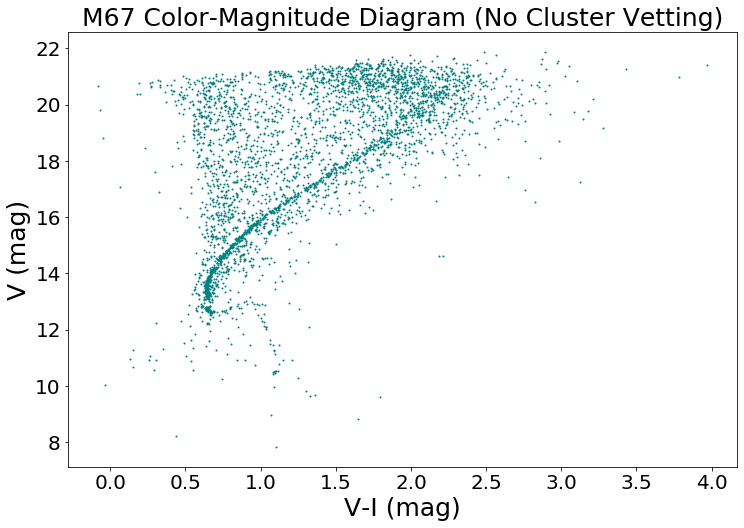

In [261]:
plt.scatter(V_I, V, s=1.0, c='teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)
plt.title('M67 Color-Magnitude Diagram (No Cluster Vetting)', fontsize=25)

plt.savefig('M67/M67_Plot1.png', dpi=150)

# Step 5: Proper Motions

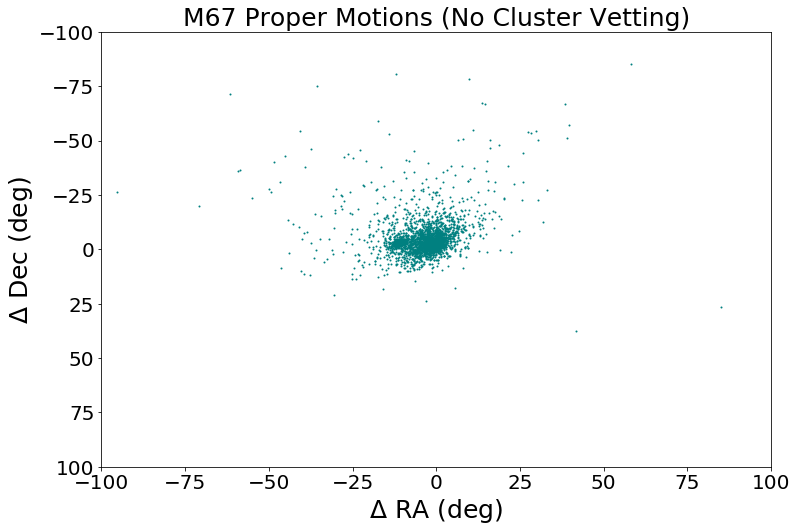

In [262]:
plt.scatter(pmra, pmdec, s=1.0, c='teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-100, 100)
plt.ylim(100, -100)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M67 Proper Motions (No Cluster Vetting)', fontsize=25)

plt.savefig('M67/M67_Plot2.png', dpi=150)

# Step 6: Determine the Center

In [263]:
boxshape = [-15, -5, -10, 10]
cut_box(len(pmra), pmra, pmdec, boxshape)        

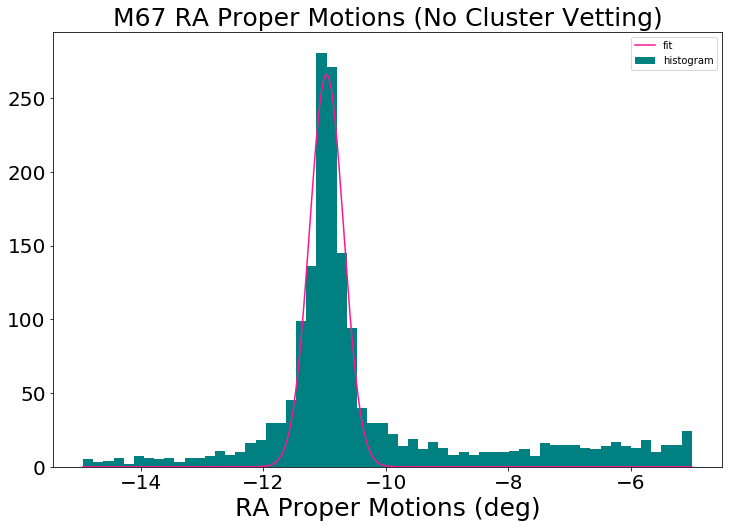

In [264]:
init_guess_a = [-11., 100., 2.]

ra_center, _, ra_sig = fit_gauss(pmra, init_guess_a)

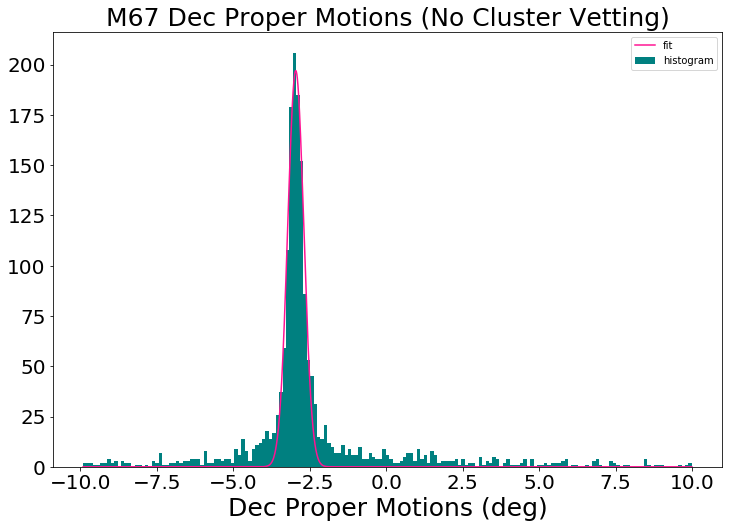

In [265]:
init_guess_b = [-3., 100., 1.]

dec_center, _, dec_sig = fit_gauss(pmdec, init_guess_b, RA=False, Dec=True)

In [266]:
# Convert parallax to arcseconds

M67df.insert(12, "parallax_arcsec", M67df['parallax']/1000., True)
M67df.insert(13, "parallax_err_arcsec", M67df['parallax_error']/1000., True)

M67df.insert(14, "distance_parsec", parallax_dist(M67df['parallax_arcsec']), True)
M67df.insert(15, "distance_err_parsec", parallax_dist_errprop(M67df['parallax_arcsec'], M67df['parallax_err_arcsec']))


M67df = M67df.drop(M67df[M67df.distance_parsec > 1800].index)

In [267]:
pmsig = np.mean((abs(ra_sig), abs(dec_sig)))

In [268]:
for index, row in M67df.iterrows():
    
    if not isInside(ra_center, dec_center, 3*pmsig, row['pmra'], row['pmdec']):
        M67df = M67df.drop(index)

In [269]:
pmra = np.array(M67df['pmra'])
pmdec = np.array(M67df['pmdec'])

g_v = gminusv(M67df['phot_bp_mean_mag']-M67df['phot_rp_mean_mag'])
g_I = gminusI(M67df['phot_bp_mean_mag']-M67df['phot_rp_mean_mag'])

V = -1*(g_v - M67df['phot_g_mean_mag'])
I = -1*(g_I - M67df['phot_g_mean_mag'])

V_I = V-I

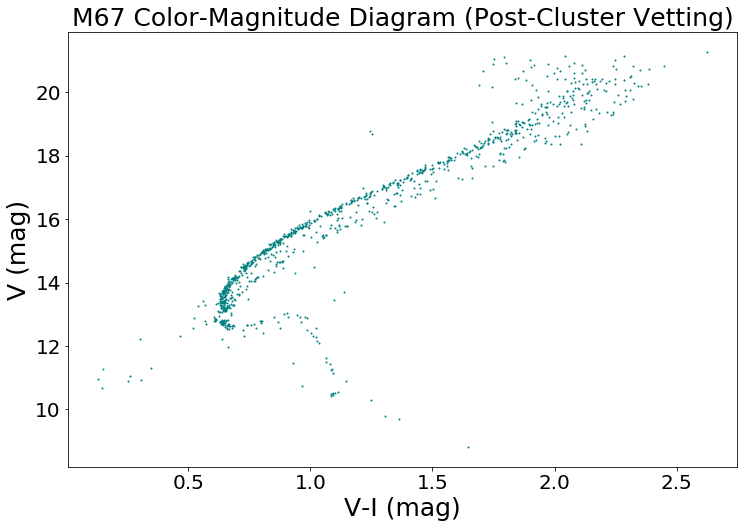

In [270]:
plt.scatter(V_I, V, s=1.0, c='teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('V-I (mag)', fontsize=25)
plt.ylabel('V (mag)', fontsize=25)
plt.title('M67 Color-Magnitude Diagram (Post-Cluster Vetting)', fontsize=25)

plt.savefig('M67/M67_Plot4.png', dpi=150)

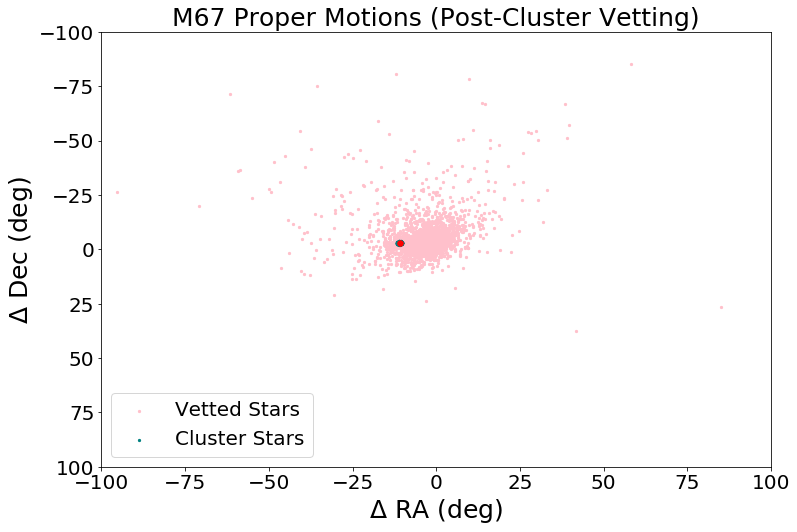

In [271]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(pmra0, pmdec0, s=5, c='pink', label='Vetted Stars')
ax.scatter(pmra, pmdec, s=5, color='teal', label='Cluster Stars')
ax.scatter(ra_center, dec_center, c='r', s=30)

plt.xlim(-100, 100)
plt.ylim(100, -100)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M67 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('M67/M67_Plot5.png', dpi=150)

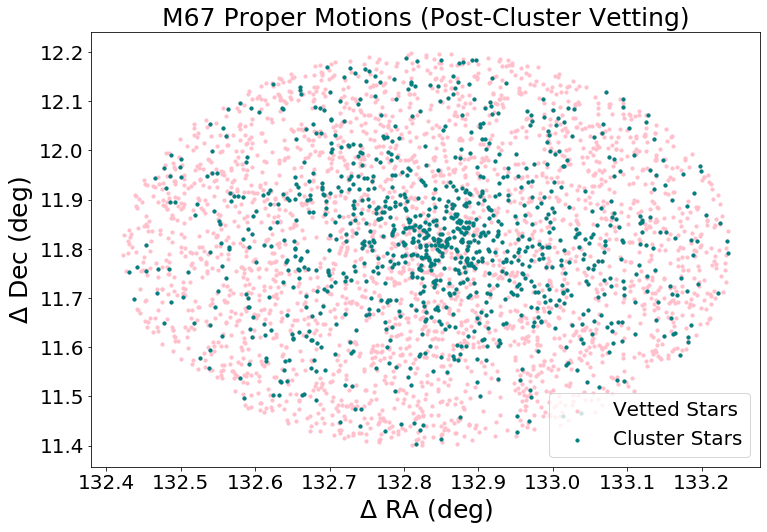

In [272]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ra0, dec0, s=10, c='pink', label='Vetted Stars')
ax.scatter(M67df['ra'], M67df['dec'], s=10, color='teal', label='Cluster Stars')

#plt.xlim(-12, -10)
#plt.ylim(-4, -2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$\Delta$ RA (deg)', fontsize=25)
plt.ylabel('$\Delta$ Dec (deg)', fontsize=25)
plt.title('M67 Proper Motions (Post-Cluster Vetting)', fontsize=25)
plt.legend(fontsize=20);

plt.savefig('M67/M67_Plot6.png', dpi=150)

# Step 7 - Parallax Histogram

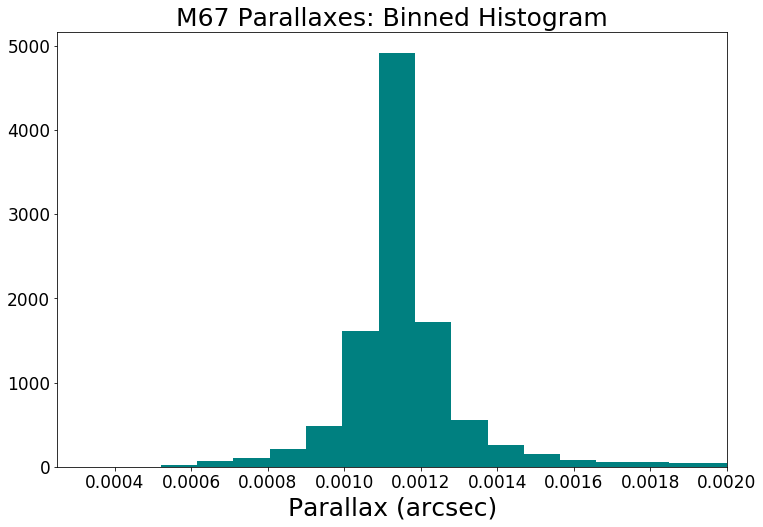

In [273]:
plt.hist(M67df['parallax_arcsec'], bins=40, density=True, color='teal');

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(0.00025, 0.002)
plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('M67 Parallaxes: Binned Histogram', fontsize=25)

plt.savefig('M67/M67_Plot7.png', dpi=150)

In [274]:
parallax_arcs = np.median(M67df['parallax_arcsec'])
parallax_err_arcs = np.std(M67df['parallax_arcsec'])/np.sqrt(len(M67df))

print('Mean cluster parallax (arcs): ', parallax_arcs)
print('Sigma of cluster parallax (arcs): ', parallax_err_arcs)

Mean cluster parallax (arcs):  0.0011410460581465125
Sigma of cluster parallax (arcs):  7.169571437822624e-06


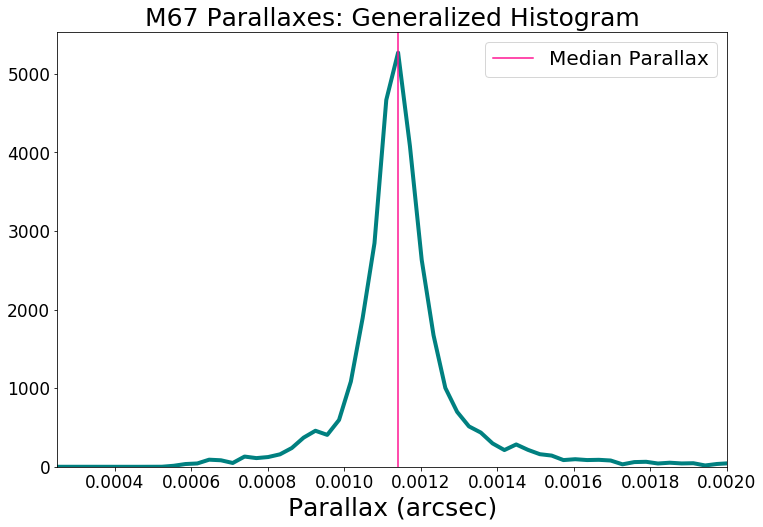

In [275]:
sns.distplot(M67df['parallax_arcsec'], hist=False, kde=True, 
             bins=25, color = 'teal',
             kde_kws={'linewidth': 4},)

plt.axvline(np.median(M67df['parallax_arcsec']), color='deeppink', label='Median Parallax')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.xlim(0.00025, 0.002)
plt.xlabel('Parallax (arcsec)', fontsize=25)
plt.title('M67 Parallaxes: Generalized Histogram', fontsize=25)
plt.legend(fontsize=20)

plt.savefig('M67/M67_Plot8.png', dpi=150)

### Define Av

In [277]:
Av = 0.094

# Step 9: Stellar Parallax

Get Stellar Distances, Absolute V mag, Absolute I mag, and Absolute V-I for all stars in cluster.

In [278]:
M67_dists = np.zeros(len(M67df))
M67_absV = np.zeros(len(M67df))
M67_absI = np.zeros(len(M67df))
M67_absVI = np.zeros(len(M67df))

M67_disterrs = np.zeros(len(M67df))
M67_absVerrs = np.zeros(len(M67df))
M67_absIerrs = np.zeros(len(M67df))
M67_absVIerrs = np.zeros(len(M67df))

V = np.array(V)
I = np.array(I)

i = 0

for index, row in M67df.iterrows():
    M67_dists[i] = parallax_dist(row['parallax_arcsec'])
    M67_disterrs[i] = parallax_dist_errprop(row['parallax_arcsec'], row['parallax_err_arcsec'])
    
    M67_absV[i] = dist_mag(M67_dists[i], V[i], Av)
    M67_absI[i] = dist_mag(M67_dists[i], I[i], Av)
    M67_absVI[i] = M67_absV[i]-M67_absI[i]
    
    
    i+=1

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in log10


In [279]:
# Get (V-I)_0
V_I_naught = V_I0(Av, V_I)

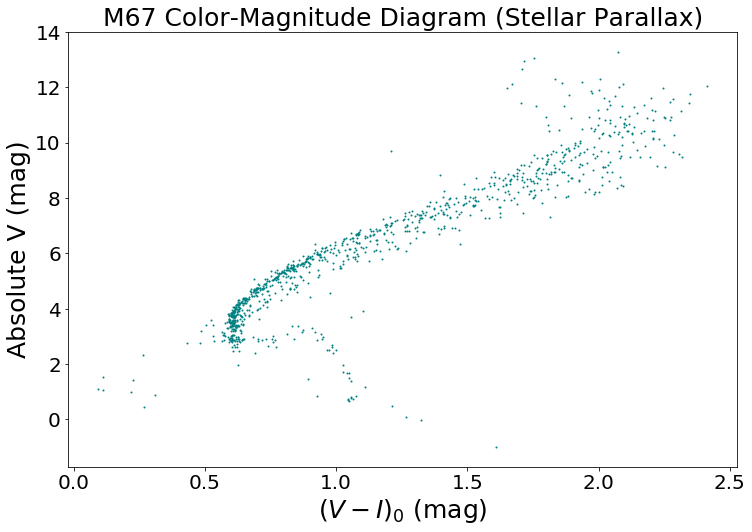

In [280]:
plt.scatter(V_I_naught, M67_absV, s=1, color='teal')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('M67 Color-Magnitude Diagram (Stellar Parallax)', fontsize=25)

plt.savefig('M67/M67_Plot9.png', dpi=150)


# Step 10: Cluster Parallax

In [281]:
cluster_dist = 1/parallax_arcs
cluster_dist_err = cluster_dist * (parallax_err_arcs/parallax_arcs)

In [282]:
print('Distance to M67: ', cluster_dist, ' parsecs')
print('Distance to M67 Error: ', cluster_dist_err, ' parsecs')

Distance to M67:  876.3888125816549  parsecs
Distance to M67 Error:  5.506642045036473  parsecs


In [283]:
M67_absV_c = np.zeros(len(M67df))
M67_absI_c = np.zeros(len(M67df))
M67_absVI_c = np.zeros(len(M67df))
M67_dmod_c = np.zeros(len(M67df))

M67_absVerrs_c = np.zeros(len(M67df))
M67_absIerrs_c = np.zeros(len(M67df))
M67_absVIerrs_c = np.zeros(len(M67df))

i = 0

for index, row in M67df.iterrows():
    M67_absV_c[i] = dist_mag(cluster_dist, V[i], Av)
    M67_absI_c[i] = dist_mag(cluster_dist, I[i], Av)
    M67_absVI_c[i] = M67_absV_c[i]-M67_absI_c[i]
    M67_dmod_c[i] = dist_mod(cluster_dist, V[i], Av)
    
    i+=1
    
    
    
    

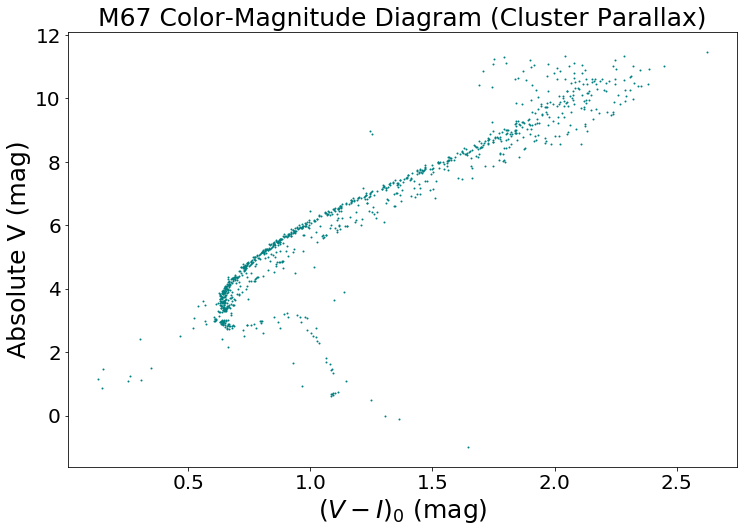

In [284]:
plt.scatter(M67_absVI_c, M67_absV_c, s=1, color='teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('$(V-I)_0$ (mag)', fontsize=25)
plt.ylabel('Absolute V (mag)', fontsize=25)
plt.title('M67 Color-Magnitude Diagram (Cluster Parallax)', fontsize=25)

plt.savefig('M67/M67_Plot10.png', dpi=150)

# Step 12: Luminosity Function

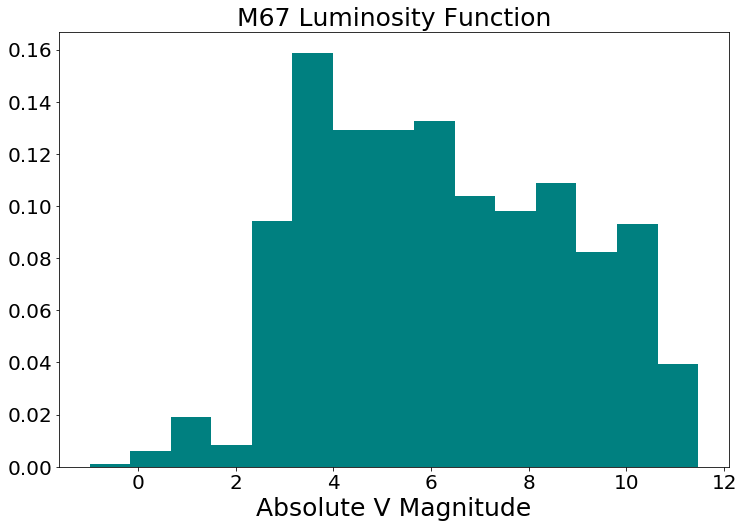

In [285]:
plt.hist(M67_absV_c, bins=15, density=1, color='teal');
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M67 Luminosity Function', fontsize=25)

plt.savefig('M67/M67_Plot11.png', dpi=150)

np.savetxt("M67lumfunc.csv", M67_absV_c, delimiter=',')

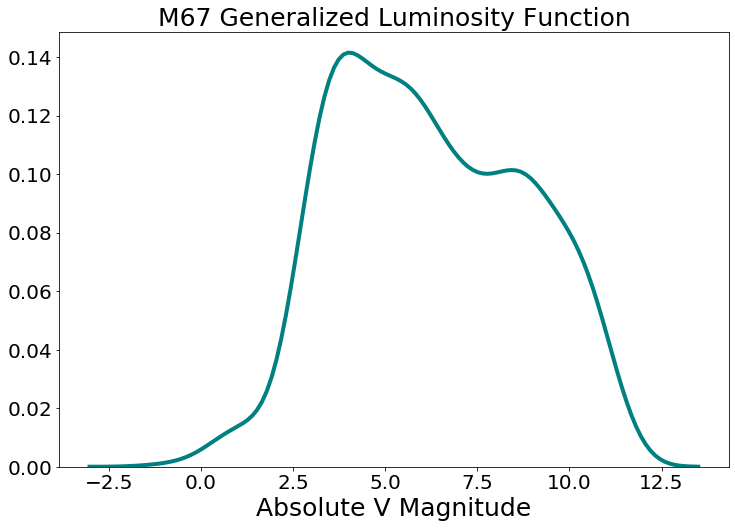

In [286]:
sns.distplot(M67_absV_c, hist=False, kde=True, 
             bins=25, color = 'teal',
             kde_kws={'linewidth': 4},)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M67 Generalized Luminosity Function', fontsize=25)

plt.savefig('M67/M67_Plot12.png', dpi=150)

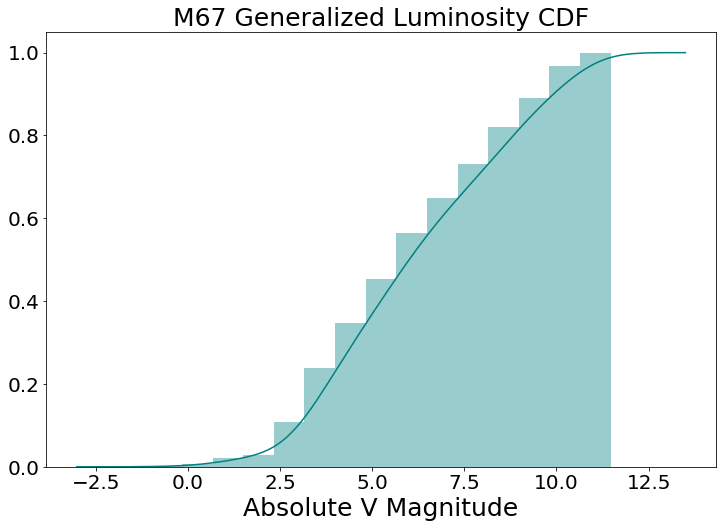

In [287]:
kwargs = {'cumulative': True}
sns.distplot(M67_absV_c, hist_kws=kwargs, kde_kws=kwargs, color = 'teal')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Absolute V Magnitude', fontsize=25)
plt.title('M67 Generalized Luminosity CDF', fontsize=25)

plt.savefig('M67/M67_Plot13.png', dpi=150)